In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

In [11]:
# define tank model
def tank(Level,time,valve,DeltaP,FlowOut):
    Cv = 0.0001     # valve size
    rho = 1000.0 # water density (kg/m^3)
    A = 0.5      # tank area (m^2)
    gs = 1.0     # specific gravity
    # inlet mass flow
    FlowIn = rho * Cv * valve * np.sqrt(DeltaP/gs)
    # leak outlet flow
    LeakOut = 5.0*Level
    # calculate derivative of the Level
    if Level <= 0.0:
        dLevel_dt = 0.0 # for drained tank
    else:
        dLevel_dt = (FlowIn-FlowOut-LeakOut)/(rho*A)
    return dLevel_dt

In [12]:
tf = 900.0           # final time
n = int(tf + 1) # number of time points

# time span for the simulation, cycle every 1 sec
ts = np.linspace(0,tf,n)
delta_t = ts[1] - ts[0]

# disturbances
DP = np.zeros(n)
Fout = np.ones(n)*2.0
Fin = np.zeros(n)
Fin_sp = np.zeros(n)

# Desired level (set point)
SP = 1.0
# level initial condition
Level0 = SP

# initial valve position
valve = 30.0
# Controller bias
ubias = valve
# valve opening (0-100%)
u = np.ones(n) * valve

Cv = 0.0001     # valve size
rho = 1000.0 # water density (kg/m^3)
A = 0.5      # tank area (m^2)
gs = 1.0     # specific gravity

In [13]:
# for storing the results
z = np.ones(n)*Level0
es = np.zeros(n)
P = np.zeros(n)   # proportional
I = np.zeros(n)   # integral
ie = np.zeros(n)

# Controller tuning
# Primary level controller
Kc_1 = 6.25
tauI_1 = 50.0
# Secondary flow controller
Kc_2 = 1.5
tauI_2 = 1.0
ierr2 = 0.0

# Feedforward control
Kff = 0.0  # 1.0

# simulate with ODEINT
for i in range(n-1):
    # inlet pressure (bar) disturbance
    DP[i] = np.sin(ts[i]/10.0)* 10.0 + 12.0 

    # inlet mass flow
    Fin[i] = rho * Cv * valve * np.sqrt(DP[i]/gs)

    # outlet flow (kg/sec) disturbance (change every 10 seconds)
    if np.mod(i+1,500)==100:
        Fout[i] = Fout[i-1] + 10.0
    elif np.mod(i+1,500)==350:
        Fout[i] = Fout[i-1] - 10.0
    else:
        if i>=1:
            Fout[i] = Fout[i-1]

    # PI controller (Primary Level Control)
    # calculate the error
    error = SP - Level0
    P[i] = Kc_1 * error
    if i >= 1:  # calculate starting on second cycle
        ie[i] = ie[i-1] + error * delta_t
        I[i] = (Kc_1/tauI_1) * ie[i]
    Fin_sp[i] = Fin[0] + P[i] + I[i] + Kff * (Fout[i]-Fout[0])
    if Fin_sp[i] > 40.0:  # check upper limit
        Fin_sp[i] = 40.0
        ie[i] = ie[i] - error * delta_t # anti-reset windup
    if Fin_sp[i] < 0.0:    # check lower limit
        Fin_sp[i] = 0.0
        ie[i] = ie[i] - error * delta_t # anti-reset windup

    # PI controller (Secondary Flow Control)
    # calculate the error
    error2 = Fin_sp[i] - Fin[i]
    P2 = Kc_2 * error2
    ierr2 = ierr2 + error2 * delta_t
    I2 = (Kc_2/tauI_2) * ierr2
    valve = u[0] + P2 + I2
    if valve > 100.0:  # check upper limit
        valve = 100.0
        ierr2 = ierr2 - error2 * delta_t # anti-reset windup
    if valve < 0.0:    # check lower limit
        valve = 0.0
        ierr2 = ierr2 - error2 * delta_t # anti-reset windup

    u[i+1] = valve   # store the valve position
    es[i+1] = error  # store the error 
    y = odeint(tank,Level0,[0,0.1],args=(valve,DP[i],Fout[i]))
    Level0 = y[-1] # take the last point
    z[i+1] = Level0 # store the level for plotting
Fout[n-1] = Fout[n-2]
DP[n-1] = DP[n-2]
Fin[n-1] = Fin[n-2]
Fin_sp[n-1] = Fin_sp[n-2]
ie[n-1] = ie[n-2]

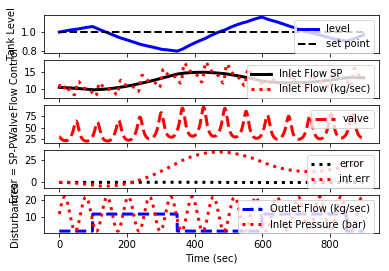

In [14]:
# plot results
plt.figure()
plt.subplot(5,1,1)
plt.plot(ts,z,'b-',linewidth=3,label='level')
plt.plot([0,max(ts)],[SP,SP],'k--',linewidth=2,label='set point')
plt.ylabel('Tank Level')
plt.legend(loc=1)
plt.subplot(5,1,2)
plt.plot(ts,Fin_sp,'k-',linewidth=3,label='Inlet Flow SP')
plt.plot(ts,Fin,'r:',linewidth=3,label='Inlet Flow (kg/sec)')
plt.ylabel('Flow Control')
plt.legend(loc=1)
plt.subplot(5,1,3)
plt.plot(ts,u,'r--',linewidth=3,label='valve')
plt.ylabel('Valve')    
plt.legend(loc=1)
plt.subplot(5,1,4)
plt.plot(ts,es,'k:',linewidth=3,label='error')
plt.plot(ts,ie,'r:',linewidth=3,label='int err')
plt.legend(loc=1)
plt.ylabel('Error = SP-PV')    
plt.subplot(5,1,5)
plt.plot(ts,Fout,'b--',linewidth=3,label='Outlet Flow (kg/sec)')
plt.plot(ts,DP,'r:',linewidth=3,label='Inlet Pressure (bar)')
plt.ylabel('Disturbances')    
plt.xlabel('Time (sec)')
plt.legend(loc=1)

plt.show()